# Rhyme

In [1]:
# !pip install -r ../requirements.txt
import sys
sys.path.append('../')
from generative_formalism import *

In [82]:
def get_df_genai():
    df_prompts=get_rhyme_for_sample('../data/corpus_genai_promptings.csv.gz').assign(source='genai')
    excl_models = {'llama2-uncensored:7b', 'ollama/llama2-uncensored:latest','ollama/darkmoon/olmo:7B-instruct-q6-k','ollama/deepseek-r1:8b'}

    def get_model_renamed(x):
        if 'gpt-3' in x:
            return 'ChatGPT'
        if 'gpt-4' in x:
            return 'ChatGPT'
        elif 'claude-3' in x:
            return 'Claude'
        elif 'llama3' in x:
            return 'Llama'
        elif 'olmo2' in x:
            return 'Olmo'
        elif 'deepseek' in x:
            return 'DeepSeek'
        elif 'gemini' in x:
            return 'Gemini'
        else:
            return x

    df_prompts = df_prompts[~df_prompts.model.isin(excl_models)]    
    df_prompts['period'] = df_prompts.model.apply(get_model_renamed)
    df_prompts['subcorpus'] = df_prompts.prompt_type
    df_prompts['rhyme'] = [('y' if 'DO_rhyme' == x else ('n' if 'do_NOT_rhyme' == x else '?')) for x in df_prompts.prompt_type]
    df_prompts.rhyme.value_counts()
    return df_prompts

In [83]:
def get_df_both():

    df_corpus=get_rhyme_for_sample('../data/corpus_sample_by_period.csv.gz').assign(source='corpus')
    df_prompts=get_df_genai()


    df_both = pd.concat([df_corpus.assign(source='Historical poems'), df_prompts.assign(source='Generative poems')]).fillna('')

    subcorpus_names = {
        '': '(n/a)',
        'DO_rhyme': 'Rhymed',
        'do_NOT_rhyme': 'Unrhymed',
        'MAYBE_rhyme': 'Rhyme unspecified',
    }
    df_both['prompt_type'] = df_both.prompt_type.apply(lambda x: subcorpus_names.get(x,x))
    df_both['subcorpus'] = [f'{y}: {subcorpus_names.get(x,x)}' for x, y in zip(df_both.subcorpus, df_both.source)]
    return df_both

In [84]:
df_both = get_df_both()
df_both.period.value_counts()

period
Llama        3205
Olmo         3041
ChatGPT      3022
Claude       2976
1850-1900    1000
1800-1850    1000
1900-1950    1000
1950-2000    1000
1700-1750     998
1750-1800     992
1650-1700     991
1600-1650     983
Gemini        931
DeepSeek      668
Name: count, dtype: int64

In [85]:
def get_avgs_df2(df, gby=['period','source','prompt_type'], y='rhyme_pred_perc'):
    stats_df = df.groupby(gby)[y].agg(
        mean=np.mean,
        stderr=lambda x: x.std() / np.sqrt(len(x)),
        count=len
    ).reset_index()
    return stats_df

In [86]:
get_avgs_df2(df_both)

,period,source,prompt_type,mean,stderr,count
0,1600-1650,Historical poems,(n/a),91.251272,0.901646,983
1,1650-1700,Historical poems,(n/a),89.606458,0.969915,991
2,1700-1750,Historical poems,(n/a),88.376754,1.015045,998
3,1750-1800,Historical poems,(n/a),87.298387,1.057781,992
4,1800-1850,Historical poems,(n/a),86.900000,1.067487,1000
...,...,...,...,...,...,...
21,Llama,Generative poems,Rhymed,96.551724,0.529386,1189
22,Llama,Generative poems,Unrhymed,24.667189,1.206776,1277
23,Olmo,Generative poems,Rhyme unspecified,97.041420,0.652181,676
24,Olmo,Generative poems,Rhymed,93.428345,0.697505,1263


In [87]:
get_avgs_df2(df_both, gby=['prompt_type'])[['prompt_type','mean']]

,prompt_type,mean
0,(n/a),66.951281
1,Rhyme unspecified,95.221647
2,Rhymed,95.240804
3,Unrhymed,49.578018


In [88]:
get_avgs_df2(df_both, gby=['period','prompt_type'])[['prompt_type','period','mean']].query('prompt_type=="Unrhymed"')

,prompt_type,period,mean
10,Unrhymed,ChatGPT,18.389753
13,Unrhymed,Claude,45.884413
16,Unrhymed,DeepSeek,31.147541
19,Unrhymed,Gemini,93.688119
22,Unrhymed,Llama,24.667189
25,Unrhymed,Olmo,83.030853


In [89]:
get_avgs_df2(df_both, gby=['period','prompt_type'])[['prompt_type','period','mean']].query('prompt_type=="Rhyme unspecified"')


,prompt_type,period,mean
8,Rhyme unspecified,ChatGPT,91.432069
11,Rhyme unspecified,Claude,93.093093
14,Rhyme unspecified,DeepSeek,98.214286
17,Rhyme unspecified,Gemini,96.000000
20,Rhyme unspecified,Llama,99.864682
23,Rhyme unspecified,Olmo,97.041420


In [120]:
def plot_predicted_rhyme_avgs(df, y='rhyme_pred_perc', x='period', gby=['period','source'], color=None, limits=[0,100], min_size=10):
    figdf = get_avgs_df2(df, gby=gby, y=y)
    figdf['source'] = pd.Categorical(figdf.source, categories=['Historical poems', 'Generative poems'])
    periods = list(df[x].unique())
    figdf[x] = pd.Categorical(figdf[x], categories=sorted(periods, reverse=False))

    p = (
        p9.ggplot(
            figdf,
            p9.aes(
                x=x,
                y='mean',
                **({'color': color, 'group': color} if color else {})
            )
        )
        + p9.geom_line()
        + p9.geom_errorbar(
            p9.aes(ymin='mean - stderr',
                  ymax='mean + stderr'),
            width=0.5,
            # position=p9.position_dodge(width=0.5)
        )
        # + p9.geom_point(p9.aes(size='count'), shape='o',alpha=.2)
        + p9.geom_hline(yintercept=50, color='black', linetype='dashed', size=.5, alpha=.5)
        + p9.theme(legend_position='bottom')
        + p9.theme_minimal()
        + p9.theme(panel_background=p9.element_rect(fill='white'), plot_background=p9.element_rect(fill='white'))
        + p9.scale_y_continuous(limits=limits)
    )

    return p

def plot_both(df_both, y='rhyme_pred_perc', gby=['period', 'rhyme', 'source'], color='rhyme'):
    p9.options.figure_size=(10,5)
    figdf = df_both[df_both.rhyme.isin({"y", "n", "?"})]
    figdf['rhyme']=figdf.rhyme.apply(lambda x: 'Yes rhyme' if x == 'y' else ('No rhyme' if x == 'n' else '(Unspecified)'))
    fig = (
        plot_predicted_rhyme_avgs(
            figdf,
            y=y,
            gby=gby,
            color=color,
        )
        + p9.theme(axis_text_x=p9.element_text(angle=45))
        + p9.facet_wrap("source", scales="free_x")
        + p9.labs(
            color='Prompt type',
            y='Predicted percentage of rhyming poems',
            x='Historical period / Generative model',
            title='Predicted percentage of rhyming poems by historical period and generative model',
            size='Number of poems'
        )
    )
    fig.save(f'../figures/predicted_rhyme_avgs_{y}_std.png')
    return fig

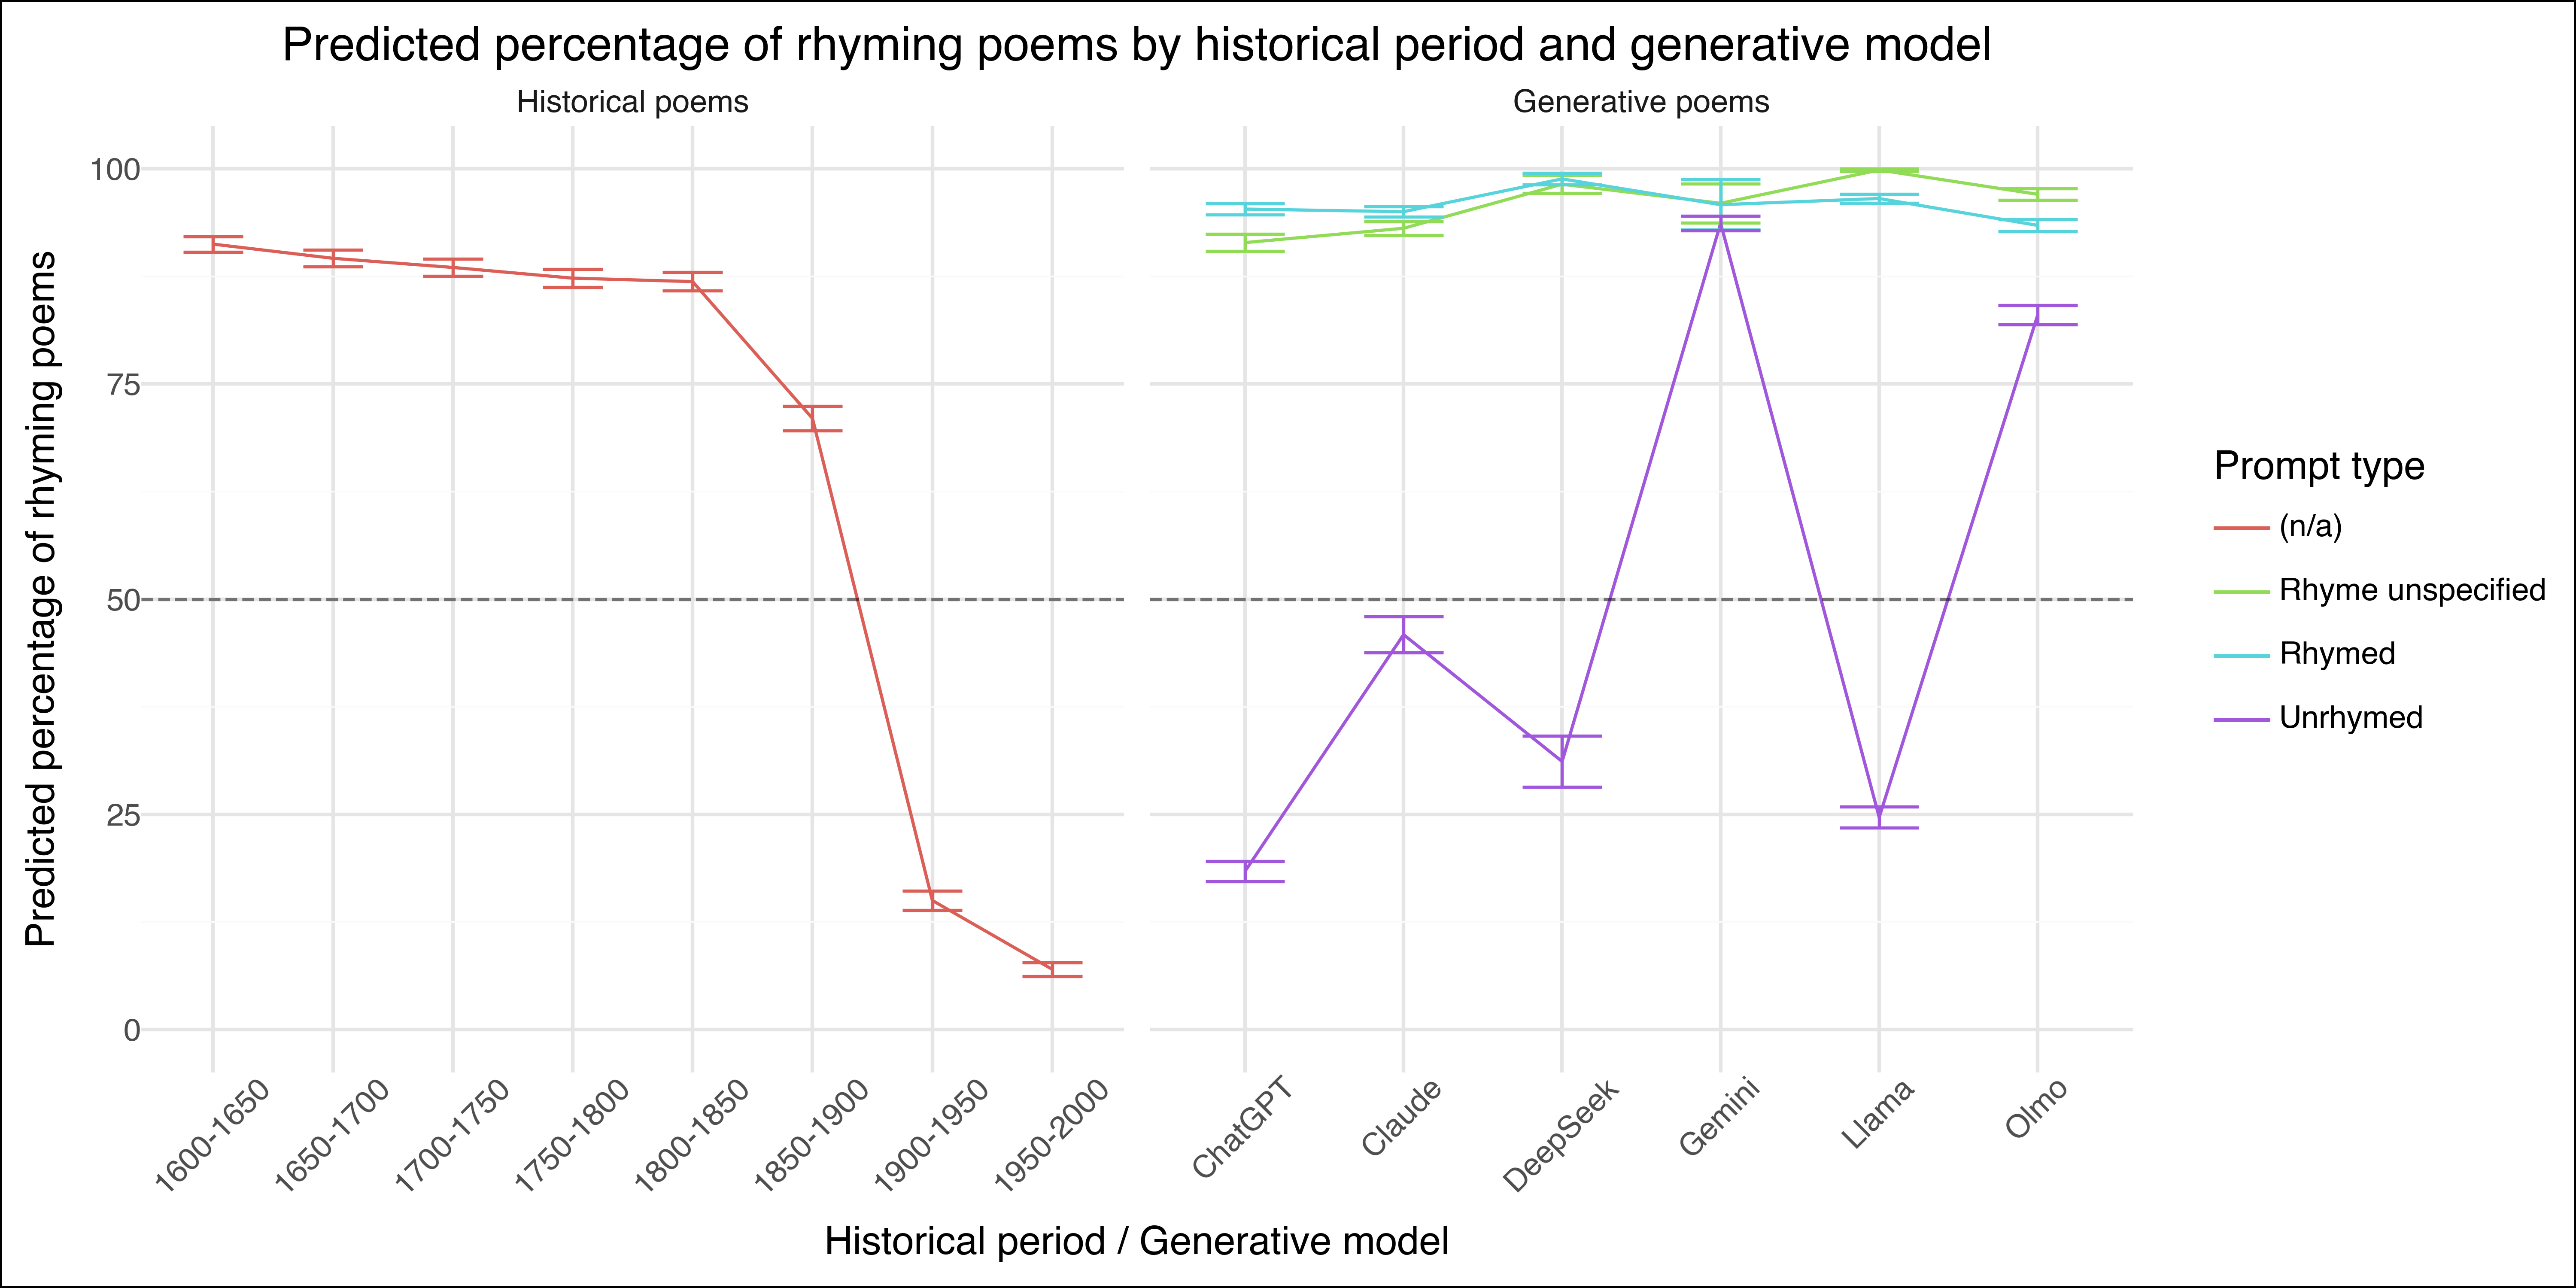

In [121]:
plot_both(df_both, y='rhyme_pred_perc', gby=['period', 'prompt_type', 'source'], color='prompt_type')

## By prompt

In [126]:
def plot_fig_avgs_prompts(x='prompt', color='period', model='ChatGPT-3.5 (OpenAI)', y='rhyme_pred_perc'):
    p9.options.figure_size=(16,10)
    figdf=df_both.query('source=="Generative poems"')
    # Convert mixed type columns to string to avoid comparison errors
    figdf[x] = figdf[x].astype(str)
    if color in figdf.columns:
        figdf[color] = figdf[color].astype(str)
    
    stats_df = get_avgs_df2(figdf, gby=[x, color], y=y)
    
    # prompts = list(figdf.sort_values('prompt_type').prompt.drop_duplicates())
    prompts = stats_df.groupby(x)['mean'].median().sort_values().index
    stats_df['prompt'] = pd.Categorical(stats_df['prompt'], categories=prompts)
    
    # Get unique prompt types and assign colors
    if 'prompt_type' in figdf.columns:
        prompt_types = figdf['prompt_type'].unique()
        Set1 = [
        # '#e41a1c',  # Red
        '#377eb8',  # Blue
        '#984ea3',  # Purple
        '#4daf4a',  # Green
        '#ff7f00',  # Orange
        '#ffff33',  # Yellow
        '#a65628',  # Brown
        '#f781bf',  # Pink
        '#999999'   # Gray
        ]
        prompt_type_colors = dict(zip(prompt_types, Set1))
        
        # Map prompts to their types and colors
        prompt_to_type = figdf.set_index('prompt')['prompt_type'].to_dict()
        prompt_colors = {prompt: prompt_type_colors[prompt_to_type[prompt]] 
                        for prompt in prompts if prompt in prompt_to_type}
    
    # Create the plot with error bars
    fig = (p9.ggplot(stats_df, p9.aes(x=x, y='mean'))
        # + p9.geom_point(
        #     p9.aes(size='count'),
        #     shape='o',
        #     alpha=.2
        # )
        + p9.geom_line(p9.aes(group=color), linetype='dashed', alpha=.5)
        + p9.geom_errorbar(
            p9.aes(ymin='mean - stderr',
                  ymax='mean + stderr'),
            width=0.5,
            # position=p9.position_dodge(width=0.5)
        )
        + p9.labs(
            x='Model',
            y='Percentage of poems rhyming',
            title='Likelihood of rhyming poems across prompts'
        )
        + p9.theme_minimal()
        + p9.coord_flip()
        + p9.scale_y_continuous(limits=[0,100])
        + p9.geom_hline(yintercept=50, linetype='dashed', color='gray', alpha=.5)
        + p9.facet_wrap('period', nrow=2)
        + p9.theme(plot_background=p9.element_rect(fill='white'), panel_background=p9.element_rect(fill='white'))
    )
    
    # Customize axis text colors based on prompt_type
    if 'prompt_type' in figdf.columns:
        # Create a theme element to color the axis text
        colored_theme = p9.theme(
            axis_text_y=p9.element_text(color=[prompt_colors.get(tick, 'black') for tick in prompts])
        )
        fig = fig + colored_theme
    fig.save(f'../figures/rhyme_avgs_by_prompt.png')

    return fig

In [127]:
plot_fig_avgs_prompts()